In [82]:
import os
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [83]:
CURRENT_DIR = os.getcwd()
BASE_DIR = os.path.dirname(CURRENT_DIR)
data_dir = os.path.join(BASE_DIR, 'data')

dataset_path = os.path.join(data_dir, 'telatmalambaru3.csv')
DEFAULT_MODEL_NAME = 'multi'

In [84]:
df = pd.read_csv(dataset_path, usecols=['TITLE', 'CATEGORY'])
df.head()

,TITLE,CATEGORY
0,SMP Matematika Bilangan,p
1,SMP Matematika Himpunan,p
2,SMP Matematika Bentuk Aljabar dan Operasinya,p
3,SMP Matematika Persamaan dan Pertidaksamaan Li...,p
4,SMP Matematika Perbandingan,p


In [85]:
duplicate_title_distribution = df.TITLE.value_counts()[:10]
duplicate_title_distribution

SMP Bahasa Indonesia Buku Fiksi dan Nonfiksi                         4
SMA Matematika Wajib Perbandingan Trigonometri                       2
SMA Matematika Peminatan Eksponen                                    2
SMP Bahasa Indonesia Teks Ulasan                                     2
SMA Bahasa Indonesia Teks Eksplanasi                                 2
SMP Matematika Statistika                                            2
SMA Matematika Wajib Permutasi dan Kombinasi                         2
SMA Matematika Peminatan Kedudukan Titik dan Garis Pada Lingkaran    2
SMA Matematika Peminatan Pertidaksamaan Eksponen dan Logaritma       2
SMP IPA Klasifikasi Mahkluk Hidup                                    2
Name: TITLE, dtype: int64

In [86]:
most_common_title = duplicate_title_distribution.index[0]
most_common_title

'SMP Bahasa Indonesia Buku Fiksi dan Nonfiksi'

In [87]:
df[df['TITLE'].str.contains(most_common_title)][:5]

,TITLE,CATEGORY
126,SMP Bahasa Indonesia Buku Fiksi dan Nonfiksi,p
127,SMP Bahasa Indonesia Buku Fiksi dan Nonfiksi,p
138,SMP Bahasa Indonesia Buku Fiksi dan Nonfiksi,p
139,SMP Bahasa Indonesia Buku Fiksi dan Nonfiksi,p


In [88]:
df = df.drop_duplicates(subset='TITLE', keep=False)
df[df['TITLE'].str.contains(most_common_title)]

,TITLE,CATEGORY


In [89]:
category_dict = {
    'p': 'smp', 
    'u': 'smaumum', 
    'a': 'smaipa', 
    's': 'smaips'
}
df.CATEGORY.value_counts()

a    165
u    142
p    120
s     65
Name: CATEGORY, dtype: int64

In [90]:
category_labels = {
    'p': 'smp', 
    'u': 'smaumum', 
    'a': 'smaipa', 
    's': 'smaips'
}

In [91]:
max_num_of_labels = df.CATEGORY.value_counts()[-1]
data_df = df.copy()
shuffled_df = data_df.reindex(np.random.permutation(data_df.index))\

p = shuffled_df[shuffled_df['CATEGORY'] == 'p'][:max_num_of_labels]
u = shuffled_df[shuffled_df['CATEGORY'] == 'u'][:max_num_of_labels]
a = shuffled_df[shuffled_df['CATEGORY'] == 'a'][:max_num_of_labels]
s = shuffled_df[shuffled_df['CATEGORY'] == 's'][:max_num_of_labels]

concated_df = pd.concat([p,u,a,s], ignore_index=True)
concated_df = concated_df.reindex(np.random.permutation(concated_df.index))
concated_df['LABEL'] = 0
concated_df.head()

,TITLE,CATEGORY,LABEL
51,SMP Bahasa Indonesia Struktur Teks Persuasi,p,0
168,SMA Fisika Gelombang Cahaya,a,0
29,SMP IPA Zat Aditif dan Zat Adiktif,p,0
32,SMP IPA Asam Basa dan Garam,p,0
71,SMA Matematika Wajib Subtitusi Dasar,u,0


In [92]:
concated_df.loc[concated_df['CATEGORY'] == 'p', 'LABEL'] = 0
concated_df.loc[concated_df['CATEGORY'] == 'u', 'LABEL'] = 1
concated_df.loc[concated_df['CATEGORY'] == 'a', 'LABEL'] = 2
concated_df.loc[concated_df['CATEGORY'] == 's', 'LABEL'] = 3
print(concated_df['LABEL'][:10])
labels = to_categorical(concated_df['LABEL'], num_classes=4)
print(labels[:10])
if 'CATEGORY' in concated_df.keys():
    concated_df = concated_df.drop(['CATEGORY'], axis=1)
'''
 [1. 0. 0. 0.] p
 [0. 1. 0. 0.] u
 [0. 0. 1. 0.] a
 [0. 0. 0. 1.] s
'''

51     0
168    2
29     0
32     0
71     1
248    3
242    3
66     1
43     0
241    3
Name: LABEL, dtype: int64
[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


'\n [1. 0. 0. 0.] p\n [0. 1. 0. 0.] u\n [0. 0. 1. 0.] a\n [0. 0. 0. 1.] s\n'

In [93]:
concated_df.head()

,TITLE,LABEL
51,SMP Bahasa Indonesia Struktur Teks Persuasi,0
168,SMA Fisika Gelombang Cahaya,2
29,SMP IPA Zat Aditif dan Zat Adiktif,0
32,SMP IPA Asam Basa dan Garam,0
71,SMA Matematika Wajib Subtitusi Dasar,1


In [94]:
n_most_common_words = 8000
max_len = 130
token_filter = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'
tokenizer = Tokenizer(num_words=n_most_common_words, filters=token_filter, lower=True)
tokenizer.fit_on_texts(concated_df['TITLE'].values)

In [95]:
sequences = tokenizer.texts_to_sequences(concated_df['TITLE'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 466 unique tokens.


In [96]:
X = pad_sequences(sequences, maxlen=max_len)

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.25, random_state=42)

In [98]:
epochs = 50
emb_dim = 200
batch_size = 256
labels[:2]

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [99]:
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

((195, 130), (195, 4), (65, 130), (65, 4))


In [100]:
model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 130, 200)          1600000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 130, 200)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                67840     
_________________________________________________________________
dense (Dense)                (None, 4)                 260       
Total params: 1,668,100
Trainable params: 1,668,100
Non-trainable params: 0
_________________________________________________________________
None


In [101]:
training = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2)

Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 1.3836 - accuracy: 0.2628 - val_loss: 1.3849 - val_accuracy: 0.1538
Epoch 2/50
1/1 [==============================] - 0s 387ms/step - loss: 1.3792 - accuracy: 0.3333 - val_loss: 1.3832 - val_accuracy: 0.1538
Epoch 3/50
1/1 [==============================] - 0s 437ms/step - loss: 1.3721 - accuracy: 0.3269 - val_loss: 1.3817 - val_accuracy: 0.1538
Epoch 4/50
1/1 [==============================] - 0s 387ms/step - loss: 1.3765 - accuracy: 0.3077 - val_loss: 1.3801 - val_accuracy: 0.1282
Epoch 5/50
1/1 [==============================] - 0s 360ms/step - loss: 1.3719 - accuracy: 0.3269 - val_loss: 1.3784 - val_accuracy: 0.1282
Epoch 6/50
1/1 [==============================] - 0s 379ms/step - loss: 1.3572 - accuracy: 0.4103 - val_loss: 1.3765 - val_accuracy: 0.1282
Epoch 7/50
1/1 [==============================] - 0s 397ms/step - loss: 1.3546 - accuracy: 0.4359 - val_loss: 1.3744 - val_accuracy: 0.1282
Epoch 8/50
1/1 [=======

In [103]:
accr = model.evaluate(X_test, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

3/3 [==============================] - 0s 14ms/step - loss: 0.5426 - accuracy: 0.9692
Test set
  Loss: 0.543
  Accuracy: 0.969


In [104]:
accuracy = training.history['accuracy']
val_accuracy = training.history['val_accuracy']
loss = training.history['loss']
val_loss = training.history['val_loss']

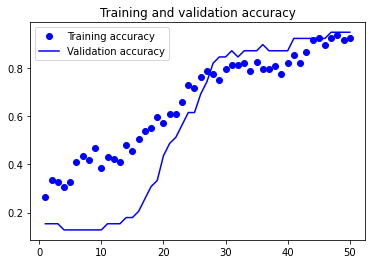

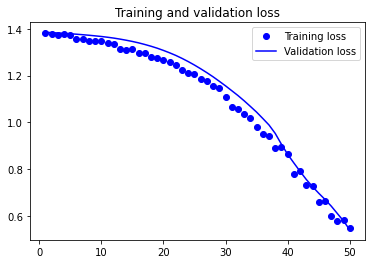

In [105]:
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [106]:
txt = ["SMP Matematika Peluang"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['smp', 'smaumum', 'smaipa', 'smaips']
print(pred, labels[np.argmax(pred)])

[[0.51517224 0.315771   0.12057854 0.04847825]] smp


In [107]:
def extract_label(index):
    '''
    The labels correspond to exact label indices, in other words, the 
    order is absolutely important.
    '''
    labels = ['smp', 'smaumum', 'smaipa', 'smaips']
    return labels[index]

In [108]:
def predict(text, model_klass=model):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len)
    pred = model_klass.predict(padded)
    top_prediction_index = np.argmax(pred)
    predicted_label = extract_label(top_prediction_index)
    predictions = pred.tolist()[0]
    extracted_predictions = [{extract_label(i):"%.2f%%"%(x*100)} for i, x in enumerate(predictions)]
    top_percent = "%.2f%%"% (predictions[top_prediction_index] * 100)
    print(f"{text}\t\t{top_percent} {predicted_label}")
    return extracted_predictions

In [110]:
predict("SMA Fisika Kimia Biologi")

SMA Fisika Kimia Biologi		76.25% smaipa


[{'smp': '3.09%'},
 {'smaumum': '6.49%'},
 {'smaipa': '76.25%'},
 {'smaips': '14.17%'}]

In [111]:
predict("SMA Bahasa Inggris Bahasa Indonesia Matematika Wajib")

SMA Bahasa Inggris Bahasa Indonesia Matematika Wajib		83.08% smaumum


[{'smp': '15.52%'},
 {'smaumum': '83.08%'},
 {'smaipa': '0.92%'},
 {'smaips': '0.48%'}]

In [112]:
predict("SMA Kimia Dan Ekonomi Sosiologi")

SMA Kimia Dan Ekonomi Sosiologi		54.24% smaips


[{'smp': '3.98%'},
 {'smaumum': '7.77%'},
 {'smaipa': '34.02%'},
 {'smaips': '54.24%'}]

In [113]:
predict("Sejarah Ekonomi dan Sosiologi")

Sejarah Ekonomi dan Sosiologi		53.95% smaips


[{'smp': '8.70%'},
 {'smaumum': '11.92%'},
 {'smaipa': '25.43%'},
 {'smaips': '53.95%'}]

In [114]:
predict("Matematika Fisika Kimia Sosiologi")

Matematika Fisika Kimia Sosiologi		45.12% smaipa


[{'smp': '16.62%'},
 {'smaumum': '19.37%'},
 {'smaipa': '45.12%'},
 {'smaips': '18.88%'}]

In [115]:
predict("SD Belajar Matematika Dasar")

SD Belajar Matematika Dasar		32.02% smaumum


[{'smp': '18.31%'},
 {'smaumum': '32.02%'},
 {'smaipa': '31.76%'},
 {'smaips': '17.91%'}]

In [116]:
model.save('saved_model')

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


In [117]:
!tensorflowjs_converter \
    --input_format=keras_saved_model \
    ./saved_model\
    ./json_keras_model

'tensorflowjs_converter' is not recognized as an internal or external command,
operable program or batch file.
